In [11]:
import torch
import torchvision.models as models

# Load the model with pre-trained weights
model = models.resnet18(weights="IMAGENET1K_V1")
model.eval()

# Ensure model and input are on the same device
device = torch.device("cpu")
model = model.to(device)

# Create a dummy input
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export the model to ONNX
try:
    torch.onnx.export(
        model,
        dummy_input,
        "resnet18.onnx",
        input_names=["input"],
        output_names=["output"],
        opset_version=11
    )
    print("Model exported successfully.")
except Exception as e:
    print(f"Export failed: {e}")

Model exported successfully.


In [12]:
import numpy as np
np.save("input.npy", dummy_input.numpy())

arr = np.load("input.npy")
print(arr.shape, arr.dtype)

(1, 3, 224, 224) float32


In [13]:
with torch.no_grad():
    output = model(dummy_input)
np.save("output.npy", output.numpy())

In [16]:
import onnx
from onnx import helper

# Load the original model
model = onnx.load("resnet18.onnx", load_external_data=True)
onnx.checker.check_model(model)

# Perform shape inference and save the inferred model
inferred_model = onnx.shape_inference.infer_shapes(model)
onnx.save(inferred_model, "resnet18_inferred.onnx")

# Use the inferred model's graph
graph = inferred_model.graph

# Create a dictionary of tensor names to shapes from value_info, inputs, and outputs
tensor_shapes = {}
for value_info in graph.value_info:
    if value_info.type.HasField("tensor_type") and value_info.type.tensor_type.HasField("shape"):
        shape = value_info.type.tensor_type.shape
        dims = [dim.dim_value if dim.dim_value else dim.dim_param or "?" for dim in shape.dim]
        tensor_shapes[value_info.name] = dims
for input_info in graph.input:
    if input_info.type.HasField("tensor_type") and input_info.type.tensor_type.HasField("shape"):
        shape = input_info.type.tensor_type.shape
        dims = [dim.dim_value if dim.dim_value else dim.dim_param or "?" for dim in shape.dim]
        tensor_shapes[input_info.name] = dims
for output_info in graph.output:
    if output_info.type.HasField("tensor_type") and output_info.type.tensor_type.HasField("shape"):
        shape = output_info.type.tensor_type.shape
        dims = [dim.dim_value if dim.dim_value else dim.dim_param or "?" for dim in shape.dim]
        tensor_shapes[output_info.name] = dims
for initializer in graph.initializer:
    dims = [dim for dim in initializer.dims]
    tensor_shapes[initializer.name] = dims

In [35]:
import onnx
import onnx.shape_inference
from onnx import helper
import graphviz
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def get_shape_str(shape):
    """Convert a TensorShapeProto or list-like object to a string."""
    # Handle list-like objects (including RepeatedScalarContainer)
    if isinstance(shape, (list, tuple)) or hasattr(shape, '__iter__'):
        dims = [str(dim) if isinstance(dim, (int, str)) else dim for dim in shape]
        return "[" + ", ".join(dims) + "]"
    # Handle TensorShapeProto
    dims = []
    for dim in shape.dim:
        if dim.dim_value:
            dims.append(str(dim.dim_value))
        elif dim.dim_param:
            dims.append(dim.dim_param)
        else:
            dims.append("?")
    return "[" + ", ".join(dims) + "]"

def create_graphviz_dot(model, output_file="output"):
    """Generate a Graphviz DOT file for the ONNX model's graph."""
    graph = model.graph

    # Create a dictionary of tensor shapes
    tensor_shapes = {}
    for value_info in graph.value_info:
        if value_info.type.HasField("tensor_type") and value_info.type.tensor_type.HasField("shape"):
            tensor_shapes[value_info.name] = value_info.type.tensor_type.shape
    for input_info in graph.input:
        if input_info.type.HasField("tensor_type") and input_info.type.tensor_type.HasField("shape"):
            tensor_shapes[input_info.name] = input_info.type.tensor_type.shape
    for output_info in graph.output:
        if output_info.type.HasField("tensor_type") and output_info.type.tensor_type.HasField("shape"):
            tensor_shapes[output_info.name] = output_info.type.tensor_type.shape
    for initializer in graph.initializer:
        tensor_shapes[initializer.name] = list(initializer.dims)  # Convert to list

    # Initialize Graphviz graph
    dot = graphviz.Digraph(comment="ResNet18 ONNX Graph", format="png")
    dot.attr(rankdir="TB")  # Top-to-bottom layout
    dot.attr("node", shape="box", style="filled", fillcolor="lightblue")
    dot.attr("edge", color="blue")

    # Add nodes for ONNX nodes
    for i, node in enumerate(graph.node):
        node_id = f"node_{i}"
        node_label = f"{node.op_type}\\nName: {node.name or 'N/A'}"
        # Add input shapes
        node_label += "\\nInputs:"
        for input_name in node.input:
            shape_str = get_shape_str(tensor_shapes.get(input_name, ["Unknown"]))
            node_label += f"\\n{input_name}: {shape_str}"
        # Add output shapes
        node_label += "\\nOutputs:"
        for output_name in node.output:
            shape_str = get_shape_str(tensor_shapes.get(output_name, ["Unknown"]))
            node_label += f"\\n{output_name}: {shape_str}"
        dot.node(node_id, node_label)

    # Add edges based on input/output connections
    tensor_to_nodes = {}
    for i, node in enumerate(graph.node):
        node_id = f"node_{i}"
        for output_name in node.output:
            tensor_to_nodes[output_name] = node_id
    for i, node in enumerate(graph.node):
        node_id = f"node_{i}"
        for input_name in node.input:
            if input_name in tensor_to_nodes:
                source_node_id = tensor_to_nodes[input_name]
                dot.edge(source_node_id, node_id, label=input_name)

    # Save the DOT file
    # dot.save(output_file + ".dot")
    print(f"Graphviz DOT file saved as {output_file}.dot")

    # Render the graph to an image
    try:
        dot.render(output_file, view=False)
        print(f"Graph rendered as {output_file}.png")
    except graphviz.ExecutableNotFound:
        print("Graphviz executable not found. Please install Graphviz and ensure 'dot' is in your PATH.")

def main():
    # Load the inferred model
    model = onnx.load("resnet18_inferred.onnx")
    onnx.checker.check_model(model)

    # Generate the Graphviz graph
    create_graphviz_dot(model, "resnet18")

if __name__ == "__main__":
    main()

Graphviz DOT file saved as resnet18.dot
Graph rendered as resnet18.png


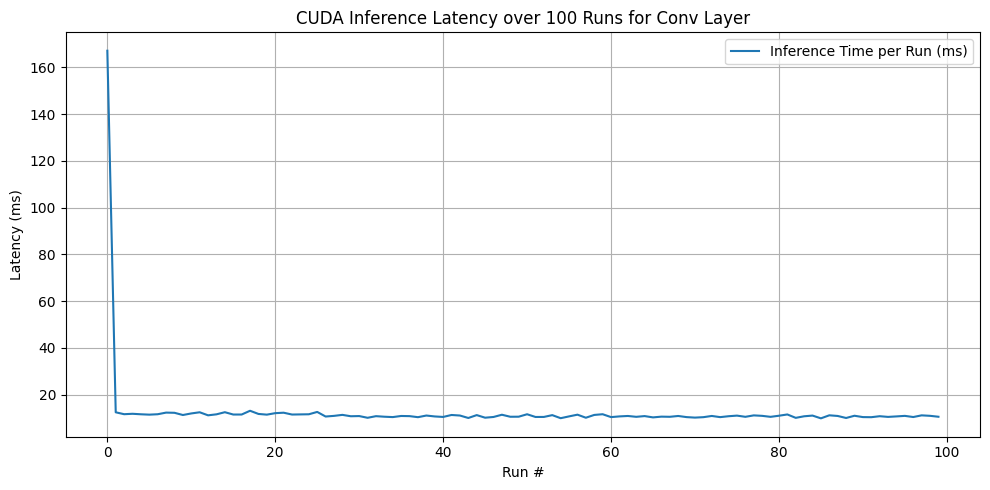

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

latency = np.loadtxt("latency.csv")

plt.figure(figsize=(10, 5))
plt.plot(latency, label="Inference Time per Run (ms)")
plt.xlabel("Run #")
plt.ylabel("Latency (ms)")
plt.title("CUDA Inference Latency over 100 Runs for Conv Layer")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("latency_plot.png")
plt.show()